100%|██████████| 1.93G/1.93G [00:27<00:00, 76.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ramanathansp20/inbreast-dataset/versions/1
  Patient ID Patient age Laterality View  Acquisition date  File Name ACR  \
0    removed     removed          R   CC            201001   22678622   4   
1    removed     removed          L   CC            201001   22678646   4   
2    removed     removed          R  MLO            201001   22678670   4   
3    removed     removed          L  MLO            201001   22678694   4   
4    removed     removed          R   CC            201001   22614074   2   

  Bi-Rads  
0       1  
1       3  
2       1  
3       3  
4       5  


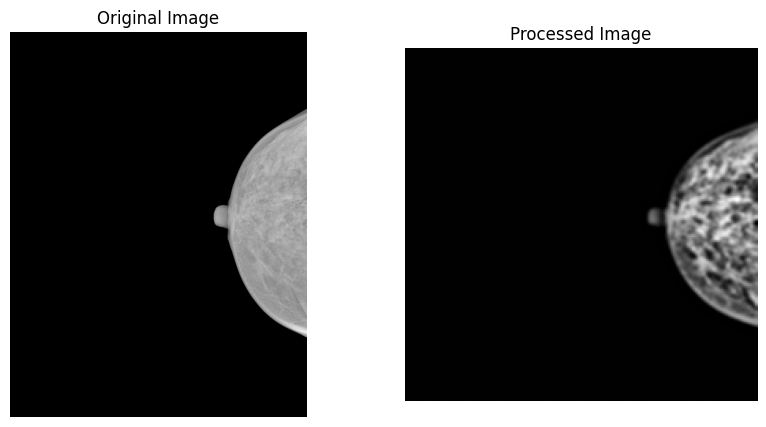

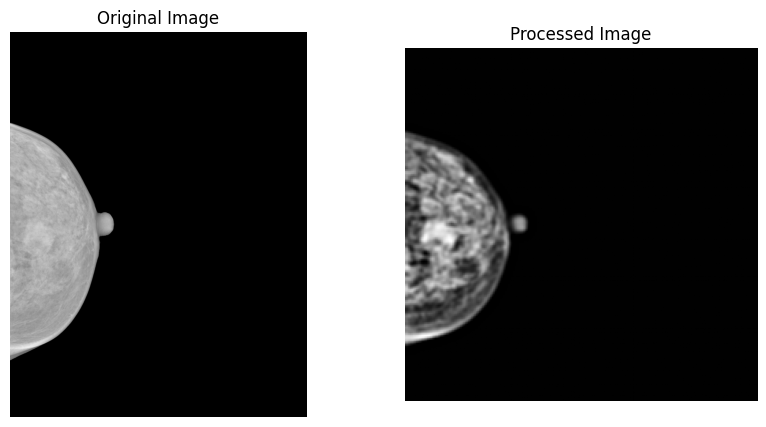

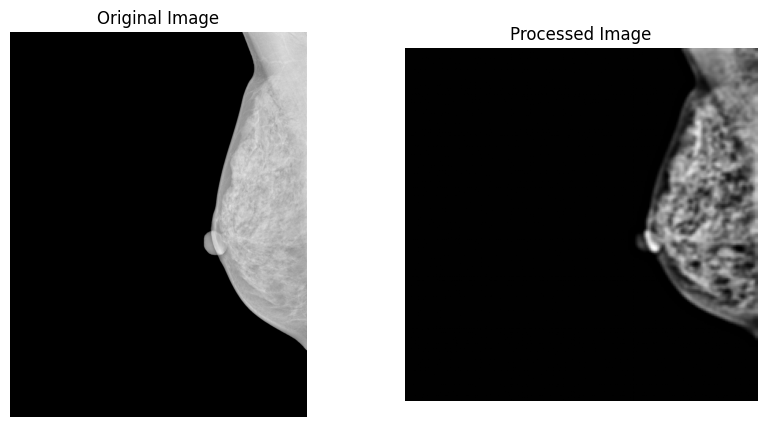

Skipping invalid Bi-Rads value: 4a
Skipping invalid Bi-Rads value: 4a
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4a
Skipping invalid Bi-Rads value: 4a
Skipping invalid Bi-Rads value: 4a
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4b
Skipping invalid Bi-Rads value: 4b
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4b
Skipping invalid Bi-Rads value: 4b
Skipping invalid Bi-Rads value: 4b
Skipping invalid Bi-Rads value: 4b
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4c
Skipping invalid Bi-Rads value: 4a
Skipping invalid Bi-Rads value: 4a
Skipping invalid Bi-Rads value: 4a
Skipping invalid Bi-

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 694ms/step

CNN Results:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        59
           1       0.00      0.00      0.00        15

    accuracy                           0.80        74
   macro avg       0.40      0.50      0.44        74
weighted avg       0.64      0.80      0.71        74

[[59  0]
 [15  0]]

Training MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

MobileNetV2 Training Progress:
Epoch 1: loss=0.6281, accuracy=0.6724, val_loss=0.5046, val_accuracy=0.7973
Epoch 2: loss=0.5955, accuracy=0.7543, val_loss=0.5123, val_accuracy=0.7973
Epoch 3: loss=0.5961, accuracy=0.7713, val_loss=0.5063, val_accuracy=0.7973
Epoch 4: loss=0.5676, accuracy=0.7611, val_loss=0.5053, val_accuracy=0.7973
Epoch 5: loss=0.6062, accuracy=0.7440, val_loss=0.5136, val_accuracy=0.7973
Epoch 6: loss=0.5625, accuracy=0.7782, val_loss=0.5041, val_accuracy=0.7973


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step

MobileNetV2 Results:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        59
           1       0.00      0.00      0.00        15

    accuracy                           0.80        74
   macro avg       0.40      0.50      0.44        74
weighted avg       0.64      0.80      0.71        74

[[59  0]
 [15  0]]


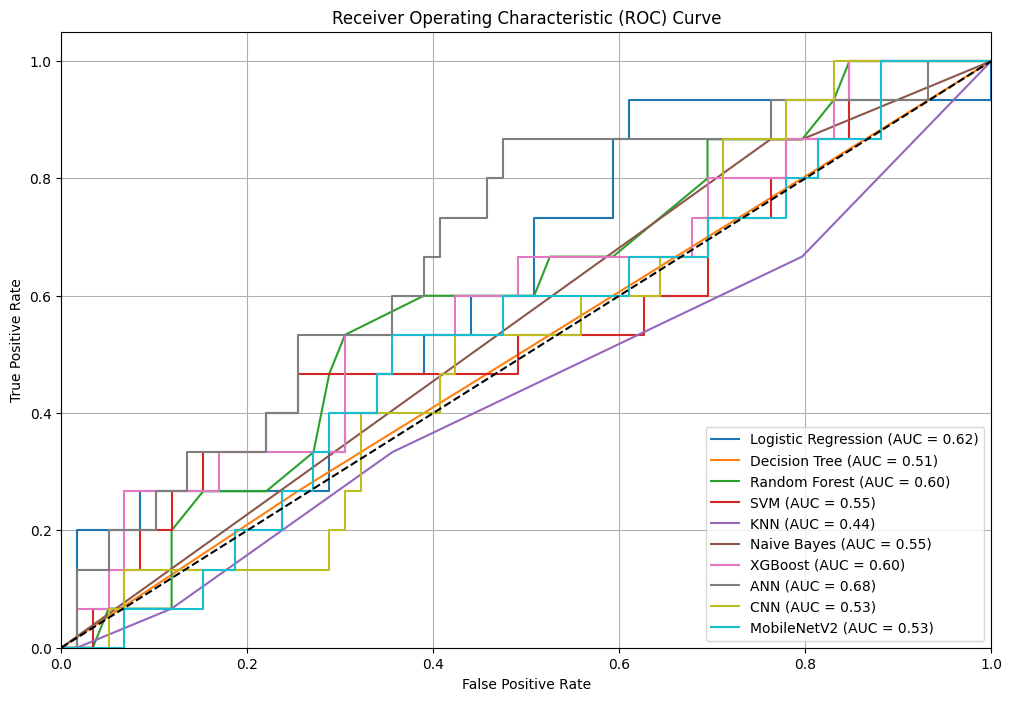

In [ ]:
# Breast Cancer Detection Using INbreast Dataset
# Import Libraries
import os
import pandas as pd
import numpy as np
import cv2
import pydicom
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
import kagglehub
from skimage import exposure
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Custom callback to print epoch details
class EpochLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}: loss={logs.get('loss', 0):.4f}, accuracy={logs.get('accuracy', 0):.4f}, val_loss={logs.get('val_loss', 0):.4f}, val_accuracy={logs.get('val_accuracy', 0):.4f}")

# Download dataset
try:
    path = kagglehub.dataset_download("ramanathansp20/inbreast-dataset")
    print("Path to dataset files:", path)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    exit()

base_path = path
dicom_path = os.path.join(base_path, "INbreast Release 1.0", "AllDICOMs")
csv_path = os.path.join(base_path, "INbreast Release 1.0", "INbreast.csv")

# Load metadata
try:
    metadata = pd.read_csv(csv_path, delimiter=';')
    print(metadata.head())
except FileNotFoundError:
    print(f"CSV file not found at {csv_path}")
    exit()

# Preprocess image function
def preprocess_image(image, visualize=False):
    try:
        if visualize:
            original_image = image.copy()

        # Resize to 224x224
        image = cv2.resize(image, (224, 224))

        # Convert to grayscale if not already
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)

        # Gaussian Blur
        image = cv2.GaussianBlur(image, (5, 5), 0)

        # Unsharp masking
        blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
        image = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

        # Normalize
        image = image / np.max(image)

        # Convert to 3-channel
        image = np.stack((image,) * 3, axis=-1)

        if visualize:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("Original Image")
            plt.imshow(original_image, cmap='gray')
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.title("Processed Image")
            plt.imshow(image[:, :, 0], cmap='gray')
            plt.axis('off')
            plt.show()

        return image
    except Exception as e:
        print(f"Error in preprocess_image: {e}")
        return None

def load_and_preprocess_dicom(metadata, dicom_path, num_visualizations=3):
    X = []
    y = []
    loaded_filenames = []
    vis_count = 0
    for index, row in metadata.iterrows():
        file_name = str(row['File Name'])
        file_path = None
        for filename in os.listdir(dicom_path):
            if filename.startswith(file_name):
                file_path = os.path.join(dicom_path, filename)
                break
        if file_path is None:
            print(f"File not found for {file_name}")
            continue

        try:
            dicom = pydicom.dcmread(file_path)
            image = dicom.pixel_array
            visualize = (vis_count < num_visualizations)
            processed_image = preprocess_image(image, visualize=visualize)
            if visualize:
                vis_count += 1
            if processed_image is None:
                continue
            X.append(img_to_array(processed_image))
            loaded_filenames.append(file_name)

            bi_rads = str(row['Bi-Rads']).strip()
            if bi_rads in ['0', '1', '2']:
                y.append(0)
            elif bi_rads in ['3', '4', '5', '6']:
                y.append(1)
            else:
                print(f"Skipping invalid Bi-Rads value: {bi_rads}")
                X.pop()
                loaded_filenames.pop()
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            continue

    if len(X) == 0:
        raise ValueError("No valid images were loaded")

    metadata_filtered = metadata[metadata['File Name'].isin(loaded_filenames)]
    return np.array(X), np.array(y), metadata_filtered

# Load data
try:
    X, y, metadata_filtered = load_and_preprocess_dicom(metadata, dicom_path, num_visualizations=3)
    print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")
except ValueError as e:
    print(f"Error: {e}")
    exit()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction using VGG19
print("\nExtracting features with VGG19...")
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

def extract_features(X, model, batch_size=32):
    features = []
    for i in range(0, len(X), batch_size):
        batch = X[i:i + batch_size]
        batch_data = vgg_preprocess(batch)
        batch_features = model.predict(batch_data, verbose=0)
        for feature in batch_features:
            features.append(feature.flatten())
    return np.array(features)

X_train_features = extract_features(X_train, model)
X_test_features = extract_features(X_test, model)

# Scale features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

# Initialize results dictionary
results = {}

# 1. Logistic Regression
print("\nTraining Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_features, y_train)
y_pred_lr = lr.predict(X_test_features)
y_proba_lr = lr.predict_proba(X_test_features)[:, 1]

print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
results['Logistic Regression'] = {'y_pred': y_pred_lr, 'y_proba': y_proba_lr}

# 2. Decision Tree
print("\nTraining Decision Tree...")
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_features, y_train)
y_pred_dt = dt.predict(X_test_features)
y_proba_dt = dt.predict_proba(X_test_features)[:, 1]

print("\nDecision Tree Results:")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))
results['Decision Tree'] = {'y_pred': y_pred_dt, 'y_proba': y_proba_dt}

# 3. Random Forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_features, y_train)
y_pred_rf = rf.predict(X_test_features)
y_proba_rf = rf.predict_proba(X_test_features)[:, 1]

print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
results['Random Forest'] = {'y_pred': y_pred_rf, 'y_proba': y_proba_rf}

# 4. SVM with GridSearch
print("\nTraining SVM with GridSearch...")
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.0001],
    'kernel': ['rbf', 'linear']
}
svm = SVC(probability=True, random_state=42)
svm_grid = GridSearchCV(svm, svm_param_grid, cv=5, n_jobs=-1, verbose=1)
svm_grid.fit(X_train_features, y_train)
best_svm = svm_grid.best_estimator_
print(f"Best SVM Parameters: {svm_grid.best_params_}")

y_pred_svm = best_svm.predict(X_test_features)
y_proba_svm = best_svm.predict_proba(X_test_features)[:, 1]

print("\nSVM Results:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))
results['SVM'] = {'y_pred': y_pred_svm, 'y_proba': y_proba_svm}

# 5. KNN
print("\nTraining KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, y_train)
y_pred_knn = knn.predict(X_test_features)
y_proba_knn = knn.predict_proba(X_test_features)[:, 1]

print("\nKNN Results:")
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
results['KNN'] = {'y_pred': y_pred_knn, 'y_proba': y_proba_knn}

# 6. Naive Bayes
print("\nTraining Naive Bayes...")
nb = GaussianNB()
nb.fit(X_train_features, y_train)
y_pred_nb = nb.predict(X_test_features)
y_proba_nb = nb.predict_proba(X_test_features)[:, 1]

print("\nNaive Bayes Results:")
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
results['Naive Bayes'] = {'y_pred': y_pred_nb, 'y_proba': y_proba_nb}

# 7. XGBoost
print("\nTraining XGBoost...")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_features, y_train)
y_pred_xgb = xgb.predict(X_test_features)
y_proba_xgb = xgb.predict_proba(X_test_features)[:, 1]

print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
results['XGBoost'] = {'y_pred': y_pred_xgb, 'y_proba': y_proba_xgb}

# 8. ANN
print("\nTraining ANN...")
ann = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_features.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\nANN Training Progress:")
history = ann.fit(X_train_features, y_train,
                 epochs=20,
                 batch_size=32,
                 validation_data=(X_test_features, y_test),
                 verbose=0,
                 callbacks=[EpochLogger()])

y_pred_ann = (ann.predict(X_test_features) > 0.5).astype(int)
y_proba_ann = ann.predict(X_test_features)

print("\nANN Results:")
print(classification_report(y_test, y_pred_ann))
print(confusion_matrix(y_test, y_pred_ann))
results['ANN'] = {'y_pred': y_pred_ann.flatten(), 'y_proba': y_proba_ann.flatten()}

# 9. CNN
print("\nTraining CNN...")
def build_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn()

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("\nCNN Training Progress:")
history = cnn.fit(datagen.flow(X_train, y_train, batch_size=32),
                 epochs=20,
                 validation_data=(X_test, y_test),
                 verbose=0,
                 callbacks=[EpochLogger()])

y_pred_cnn = (cnn.predict(X_test) > 0.5).astype(int)
y_proba_cnn = cnn.predict(X_test)

print("\nCNN Results:")
print(classification_report(y_test, y_pred_cnn))
print(confusion_matrix(y_test, y_pred_cnn))
results['CNN'] = {'y_pred': y_pred_cnn.flatten(), 'y_proba': y_proba_cnn.flatten()}

# 10. MobileNetV2
print("\nTraining MobileNetV2...")
def build_mobilenet():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

mobilenet = build_mobilenet()

# Preprocess for MobileNet
X_train_mobilenet = mobilenet_preprocess(X_train.copy())
X_test_mobilenet = mobilenet_preprocess(X_test.copy())

print("\nMobileNetV2 Training Progress:")
history = mobilenet.fit(datagen.flow(X_train_mobilenet, y_train, batch_size=32),
                       epochs=20,
                       validation_data=(X_test_mobilenet, y_test),
                       verbose=0,
                       callbacks=[EpochLogger()])

y_pred_mobilenet = (mobilenet.predict(X_test_mobilenet) > 0.5).astype(int)
y_proba_mobilenet = mobilenet.predict(X_test_mobilenet)

print("\nMobileNetV2 Results:")
print(classification_report(y_test, y_pred_mobilenet))
print(confusion_matrix(y_test, y_pred_mobilenet))
results['MobileNetV2'] = {'y_pred': y_pred_mobilenet.flatten(), 'y_proba': y_proba_mobilenet.flatten()}

# ROC Curve
plt.figure(figsize=(12, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()